# Make Obs Movie Plots
## updating prior version DyeObsMovie.py into notebook format

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 15:24:57 2019

@author: jacob
"""

import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy.ma as ma

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [18]:
#%% LOAD MET DATA

filename = '/data/pacific/jacob/LATMIXDYE/LATMIX/LES_COARE35_forcing.mat' # Front run
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

# List all groups
yearday = matfile['yearday']
tau_cs = matfile['tau_cs']
tau_d = matfile['tau_d']
qnet = matfile['net_heat_flux']
tmag = np.sqrt(tau_cs**2 + tau_d**2)

#%% LOAD SST MAP

filename = '/data/pacific/jacob/LATMIXDYE/SatData/AVHRR493data.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

sstdatafile=matfile['sstdata']

temp0 = sstdatafile[0]
temp1 = sstdatafile[1]
temp2 = sstdatafile[2]

sstdata = temp0.sst
sst=(sstdata.bytes-0.5)*sstdata.scale; 
sst[sst<0] = np.nan; 
sst=sst+sstdata.min

latgrid = temp0.subset.latgrid
longrid = temp0.subset.lonEgrid

latlimr = np.argmin(np.abs(latgrid-38))
latliml = np.argmin(np.abs(latgrid-40))
lonliml = np.argmin(np.abs(longrid+66))
lonlimr = np.argmin(np.abs(longrid+62))

#%% LOAD DYE DATA
#filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/inj_data_2012'
#matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
#matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

latK = matfile['lat_ts']
lonK = matfile['lon_ts']

depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
    #%% LOAD FLOAT DATA
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons

#sf = 10
#poly = np.polyfit(fyd,flat,6)
#flat_s = np.poly1d(poly)(fyd)
#
#window_size, poly_order = 51, 3
#flat_s = savgol_filter(flat, window_size, poly_order, deriv=0)
#flon_s = savgol_filter(flon, window_size, poly_order, deriv=0)
fvellat = np.gradient(flats)/np.gradient(fyds*86400)
fvellon = np.gradient(flons)/ np.gradient(fyds*86400)
fdir = np.arctan2(fvellat, fvellon)

filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']

In [19]:
#%% Calculated depth integrated 
# Might be easier to do from gridded data

# NB. Need to figure out how to calculate across-stream distance for each cast, otherwise
# Nb. Also need to figure out how to interpolate/plot surface density for each of these.

# 1 ) At each point, calculate distance from float
# 2 ) Using instantaneous float velocity calculate cross-stream distance

fluor_int = np.zeros((ns,))
lat_int = np.zeros((ns,))
lon_int = np.zeros((ns,))
jday_int = np.zeros((ns,))
surf_rho = np.zeros((ns,))
shiplog_int = np.zeros((ns,))
zcom_rho = np.zeros((ns,))
for i in range(0, ns):
    mask = np.isfinite(fluorppb[:,i])
    fluor_int[i] = integrate.trapz(fluorppb[mask,i], x=depth[mask,i])
    shiplog_int[i] = np.nanmean(shiplog[mask,i])
    lat_int[i] = np.nanmean(lat[:,i])
    lon_int[i] = np.nanmean(lon[:,i])
    jday_int[i] = np.nanmean(jday[:,i])
    ind = np.where(np.isfinite(rho[:,i]))[0][0]
    zcom = integrate.trapz(fluorppb[mask,i]*depth[mask,i], x=depth[mask,i])/fluor_int[i]
    surf_rho[i] = rho[ind,i]
    ind = np.argmin(np.abs(depth[:,i] - zcom))
    zcom_rho[i] = rho[ind,i]
# calc distance relative to float
iflat = np.interp(jday_int, fyds, flats)
iflon = np.interp(jday_int, fyds, flons)
distlat = (lat_int-iflat)*111e3*np.cos(lat_int)
distlon = (lon_int-iflon)*111e3

fdist = np.sign(lat_int-iflat)*np.sqrt(((lat_int - iflat)*111e3*np.cos(lat_int))**2 + ((lon_int - iflon)*111e3)**2)

#%% INTEGRATED BY CROSSING

nc, nl = II.shape
survdist = np.zeros((ns,))
weightedrho = np.zeros((nc,))
ydc = np.zeros((nc,))
shiplogc = np.zeros((nd, ns))
for i in range(0, nc-1):
    span = range(II[i,0], II[i,1])
#    distspan = fdist[span]
#    distind = np.argmin(np.abs(distspan))
    
    meanfloatlat = np.interp(np.mean(jday_int[span]), fyds, flats)
    meanfloatlon = np.interp(np.mean(jday_int[span]), fyds, flons)
    distlat = (lat_int[span]-meanfloatlat)*111e3*np.cos(lat_int[span])
    distlon = (lon_int[span]-meanfloatlon)*111e3
    distspan = np.sign(distlat)*np.sqrt(distlat**2 + distlon**2)
    distind = np.argmin(np.abs(distspan))

    tempdist = distspan - distspan[distind] # This is distance from the closest point of approach to the float for a survey
    survang = np.arctan2((lat_int[span[-1]] - lat_int[span[0]]), (lon_int[span[-1]] - lon_int[span[0]]))
    
    fvellatm = np.mean(np.interp(jday_int[span], fyds, fvellat))
    fvellonm = np.mean(np.interp(jday_int[span], fyds, fvellon))
    fang = np.arctan2(fvellatm, fvellonm)
#    print(survang*180/np.pi)
    angdif = survang - fang
#    angdif = (angdif+np.pi) % (2*np.pi) - np.pi
    print(angdif*180/np.pi)
    factor = np.sin(angdif)
    
    survdist[span] = (shiplog_int[span] - shiplog_int[span][distind])*factor
#    survdist[span] = tempdist*np.abs(factor)
    shiplogc[:,span] = (shiplog[:,span] - shiplog[:,span][:,distind][:,np.newaxis])*factor
#    print(survang*180/np.pi)
    ftemp = fluorppb[:,span]
    rtemp = rho[:,span]
    ftemp[~np.isfinite(ftemp)] = 0
    rtemp[~np.isfinite(rtemp)] = 0
    sltemp = shiplogc[:,span]
    sltemp[~np.isfinite(sltemp)] = 0
    weightedrho[i] = np.trapz(np.trapz(ftemp*rtemp, x=sltemp, axis=-1), x=depth[:,span[0]], axis=0)/np.trapz(np.trapz(ftemp, x=sltemp, axis=-1), x=depth[:,span[0]], axis=0)
    ydc[i] = np.nanmean(jday[:,span])

8.081585130149898
-67.82858711042137
34.09538421525373
-50.75901059140406
41.644602648223525
-45.199568763757775
43.93251366116403
-37.868069226317694
52.706551205024226
-38.379404144783514
53.003857074636
-25.832458456343254
58.36895452403266
-35.58837942282346
60.73339741834283
-34.7925791719591
52.70982712187736
-40.29208826573752
48.41385235343272
-45.565239946489356
61.572626719271774
-40.4084058516566
44.53633873520639
-39.76768095343488
43.61533021002288
-40.92491351153278
48.465460157529826
-56.360238954805865
40.17778689533243
-53.19714155230888
51.5321816673354
-54.76510528355531
36.35526659222465
-62.08643854843069
45.14270174534153
-50.52951186242679
55.67415267699694
-44.247028255016374
62.929077261789665
-44.363223604315145
64.09088762732648
-45.295510938417664
57.340672126111166
-50.412391619489426
57.65133352451094
-49.61795969952803
55.235193639778196
-51.88693815431058
58.50062397326401
-54.39036257463253
74.40829457827877
-42.076754858893906
67.87140443192388
-36.951

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
#%%
#    Xi, Yi = np.meshgrid(np.linspace(-10, 10, 100),np.linspace(0, 150, 150))
#    nz, nx = X.shape
#    Xa = X.reshape(nx*nz)
#    Ya = Y.reshape(nx*nz)
#    Ca = C.reshape(nx*nz)
#    Ra = r
#    mask   = np.isfinite(Xa+Ya+Ca)
#    Ci = griddata((Xa[mask], Ya[mask]), Ca[mask], (Xi,Yi))
    

NameError: name 'r' is not defined

0


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


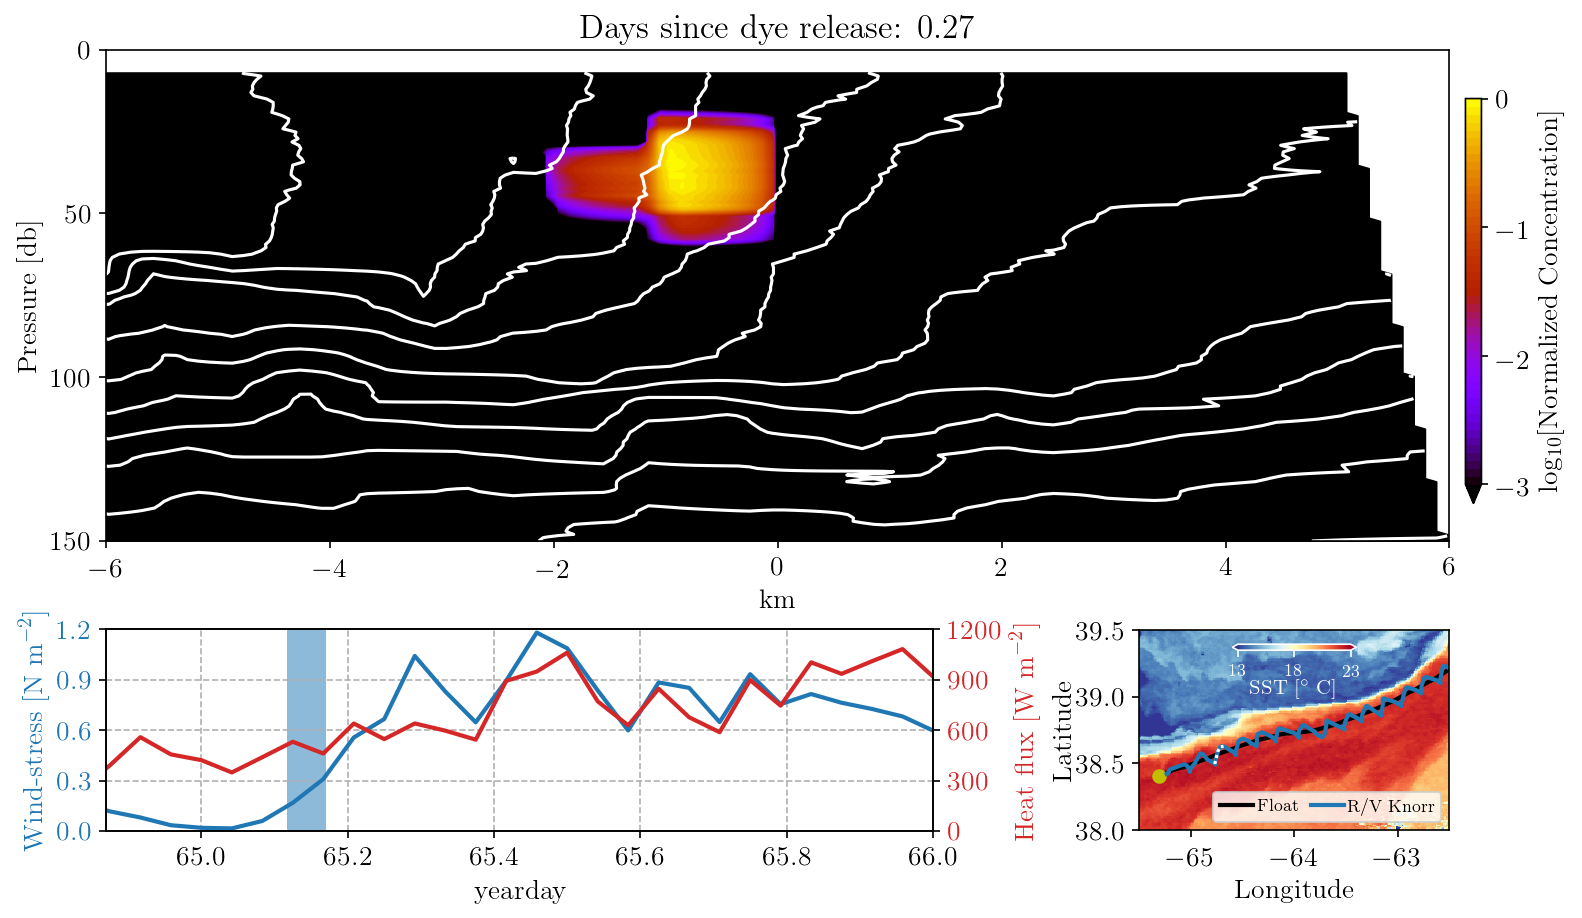

In [21]:
    
#%% MOVIE FIGURE



save = False
conts = np.linspace(-3, 0, 50)

rhoc = np.linspace(20, 30, 101)+0.06

fac = 1.5
plt.rcParams['font.size'] = 20/fac

norm = np.nanmax(fluorppb)

ckeeps = [4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]
Xi, Yi = np.meshgrid(np.linspace(-10, 10, 200),np.linspace(0, 150, 150))

#indb = np.argmin(np.abs(time_f/86400-64.87+64.5))
for i in range(0, 1+0*14, 1):
    print(i)
    fig = plt.figure(figsize=(16/fac,9/fac), dpi=fac*100)
    axdye = plt.subplot2grid((3,3), (0,0), rowspan = 2, colspan=3)

    span = range(II[ckeeps[i],0], II[ckeeps[i],1])
    X = shiplogc[:,span]
    Y = depth[:,span]
    C = fluorppb[:,span]/norm
    R = rho[:,span]
    nz, nx = X.shape
    Xa = X.reshape(nx*nz)
    Ya = Y.reshape(nx*nz)
    Ca = C.reshape(nx*nz)
    Ra = R.reshape(nx*nz)
    mask   = np.isfinite(Xa+Ya+Ca)
    Ci = griddata((Xa[mask], Ya[mask]), Ca[mask], (Xi,Yi), method='linear')
    Ri = griddata((Xa[mask], Ya[mask]), Ra[mask], (Xi,Yi), method='linear')
    cmap = 'gnuplot'
    im = axdye.contourf(Xi, Yi, np.log10(Ci), conts, extend='min', cmap=cmap)
    for c in im.collections:
        c.set_edgecolor("face")
#    im = axdye.pcolor(X, Y, np.log10(C),  vmin=-3, vmax=0,  cmap=cmap)
#    axdye.contour(X,Y, R,rhoc, colors='w')
    axdye.contour(Xi,Yi, Ri,rhoc, colors='w')

    axdye.set_ylim(0, 150)
    axdye.set_yticks([0, 50, 100, 150])
    axdye.invert_yaxis()
    axdye.set_xlabel('km')
    axdye.set_ylabel('Pressure [db]')
    mt = np.nanmean(jday[:,span])
    axdye.set_title(f'Days since dye release: {mt-64.87:3.2f}')
    axdye.set_xlim([-6, 6])
#    dyevar = np.log10(dye1_f[i,1:,:])
    
    axsst = plt.subplot2grid((3,3), (2,2), colspan=1)
    cmap = 'RdYlBu_r'
    tliml = 13
    tlimh = 23  
    aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

    isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
    isst.set_edgecolor('face')
    indrelease = np.argmin(np.abs(fyds - 64.86))
    axsst.plot(flons[indrelease:], flats[indrelease:], linewidth=2,  color='k', label='Float')
    
    axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='y')
    
    axsst.set_ylim(38.,39.5)
    axsst.set_xlim(-65.5, -62.5)
    axsst.set_aspect(aspratio)

    axsst.set_ylabel('Latitude', labelpad=-0.5)
    axsst.set_xlabel('Longitude')

           
    axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
    l1, = axsst.plot(np.nanmean(lon[:,span], axis=0), np.nanmean(lat[:,span], axis=0), color = 'w', linestyle='dashed')
    l1.set_dashes([1, 1])
    
    axsst.legend(loc=4, ncol=2, fontsize=8, handletextpad=0.2, columnspacing=0.8)

    axflux = plt.subplot2grid((3,3), (2,0), colspan=2)
    color = 'tab:blue'
    axflux.plot(yearday, tmag, color=color, linewidth=2)
    axflux.tick_params(axis='y', labelcolor=color)
    axflux.set_ylabel('Wind-stress [N m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    axflux.set_ylim((0, 1.2))
    axflux.set_yticks([0, 0.3, 0.6, 0.9,  1.2])
    axflux.set_xlim((64.5, 66))
    axflux.set_xlabel('yearday')
    
    axflux2 = axflux.twinx()
#    axflux.axvline(time_f[i]/86400+64.5, linestyle='dashed', color='k')
#    axflux.axvline(np.nanmean(jday[:,span]), linestyle='dashed', color='k')
    axflux.axvspan(np.nanmean(jday[:,span[0]]), np.nanmean(jday[:,span[-1]]), alpha=0.5)
    color = 'tab:red'
    axflux2.plot(yearday, qnet, color=color, linewidth=2)
    axflux2.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    axflux2.tick_params(axis='y', labelcolor=color)
    axflux2.set_ylim((0, 1200))
    axflux2.set_xlim((64.87, 66))
    axflux2.set_yticks([0, 300, 600, 900,  1200])
    axflux.grid(linestyle='dashed')

    plt.subplots_adjust(wspace=3.5, hspace=0.04)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.45, 0.01, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax, extend='min')
    cb.set_ticks([-3, -2, -1, 0])
    cb.set_label('log$_{10}$[Normalized Concentration]')
    
#    cbar_ax = fig.add_axes([0.91, 0.09, 0.01, 0.22])
#    cb = fig.colorbar(isst, cax=cbar_ax, extend='both')
##    cb.set_ticks([-3, -2, -1, 0])
#    cb.set_label('SST [$^\circ$ C]')
    cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
    cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
    cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=10, labelpad=-1)
    cb.outline.set_edgecolor('w')
    cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
    cb.ax.xaxis.set_tick_params(color='w')
    cb.ax.tick_params(labelsize=8)
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  

    fig.tight_layout(pad=0.2)
    
    fig.subplots_adjust(right=0.9)

    if save:
        plt.savefig(f'/home/jacob/Dropbox/GulfStreamDye/ObsMovieFigs/LatmixDyeObs_{i}.png')
        plt.close('all')
    
## TO MAKE MOVIE
# ffmpeg -start_number 0 -i LatmixDyeObs_%d.png -pix_fmt yuv420p -crf 0 -vf "setpts=48*PTS" dye_obs.mov

8.081585130149898


NameError: name 'X' is not defined